## Unzip the dataset

In [ ]:
!unzip '/content/Cardiac-Video-Sequence.zip'

# Data preprocessing

In [1]:
import numpy as np

data = np.load('Cardiac-Video-Sequence/Cardiac-Video-Sequence/2023-11-15-cine-myo-masks-and-TOS.npy', allow_pickle=True)

mask_volume = []
TOS_volume = []
time_stamps = []

for i in range(128):
    mask_volume.append(data[i]['cine_lv_myo_masks_cropped'])   # Get the myocardium mask of slice 0. It should be a (H, W, n_frames) volume
    TOS_volume.append(data[i]['TOS'])  # Get the TOS curve of slice 0. It should be a (126, n_frames) 2D array

print('Data:', mask_volume[0].shape)
print('Ground Truth', TOS_volume[0].shape)

Data: (80, 80, 25)
Ground Truth (126,)


In [2]:
import numpy as np
from numpy import pad
from sklearn.model_selection import train_test_split

# Load the dataset
data = np.load('Cardiac-Video-Sequence/Cardiac-Video-Sequence/2023-11-15-cine-myo-masks-and-TOS.npy', allow_pickle=True)

mask_volume = []
TOS_volume = []

# Extract data
for i in range(len(data)):
    mask_volume.append(data[i]['cine_lv_myo_masks_cropped'])  # Myocardium masks
    TOS_volume.append(data[i]['TOS'])  # TOS curves

# Determine the maximum dimensions
max_height = max(array.shape[0] for array in mask_volume)
max_width = max(array.shape[1] for array in mask_volume)
max_frames = max(array.shape[2] for array in mask_volume)

# Function to pad an array to the maximum size
def pad_array(array, max_height, max_width, max_frames):
    pad_height = max_height - array.shape[0]
    pad_width = max_width - array.shape[1]
    pad_frames = max_frames - array.shape[2]
    return pad(array, ((0, pad_height), (0, pad_width), (0, pad_frames)), 'constant', constant_values=0)

# Apply padding to each array
mask_volume_padded = [pad_array(array, max_height, max_width, max_frames) for array in mask_volume]

# Convert lists to numpy arrays
mask_volume = np.array(mask_volume_padded)
TOS_volume = np.array(TOS_volume)

# Normalizing the mask volumes
mask_volume = mask_volume / 255.0

# Splitting the dataset into training and testing sets
mask_volume_train, mask_volume_test, TOS_volume_train, TOS_volume_test = train_test_split(mask_volume, TOS_volume, test_size=0.2, random_state=42)

print("Training Data Shape:", mask_volume_train.shape)
print("Testing Data Shape:", mask_volume_test.shape)
print("Training Ground Truth Shape:", TOS_volume_train.shape)
print("Testing Ground Truth Shape:", TOS_volume_test.shape)


Training Data Shape: (102, 80, 80, 25)
Testing Data Shape: (26, 80, 80, 25)
Training Ground Truth Shape: (102, 126)
Testing Ground Truth Shape: (26, 126)


Check for the Pixel values.

In [3]:
import numpy as np

# Assuming 'mask_volume' is your array of myocardium masks
mask_volume = np.array(mask_volume_padded)  # Convert your list to a numpy array if not already done

# Find the minimum and maximum pixel values
min_pixel_value = mask_volume.min()
max_pixel_value = mask_volume.max()

print("Minimum Pixel Value:", min_pixel_value)
print("Maximum Pixel Value:", max_pixel_value)

# Check if the values are in the expected range
if min_pixel_value >= 0 and max_pixel_value <= 255:
    print("Pixel values are within the expected range (0-255). Normalization can proceed.")
else:
    print("Pixel values are NOT in the expected range. Please check the data.")


Minimum Pixel Value: False
Maximum Pixel Value: True
Pixel values are within the expected range (0-255). Normalization can proceed.


Making integer values to float

In [4]:
# Convert training and testing labels to integer values
TOS_volume_train_int = np.round(TOS_volume_train).astype(int)
TOS_volume_test_int = np.round(TOS_volume_test).astype(int)

print("Training Ground Truth Shape:", TOS_volume_train_int.shape)
print("Testing Ground Truth Shape:", TOS_volume_test_int.shape)

Training Ground Truth Shape: (102, 126)
Testing Ground Truth Shape: (26, 126)


## 3D CNN with few layers

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define 3D CNN
def create_3d_cnn(input_shape, num_outputs):
    model = models.Sequential()
    model.add(layers.Conv3D(64, (3, 3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling3D((2, 2, 2)))
    model.add(layers.Conv3D(128, (3, 3, 3), activation='relu'))
    model.add(layers.MaxPooling3D((2, 2, 2)))
    model.add(layers.Conv3D(256, (3, 3, 3), activation='relu'))
    model.add(layers.GlobalAveragePooling3D())
    model.add(layers.Dropout(0.3))  # Dropout for regularization
    model.add(layers.Dense(num_outputs))  # Final output layer
    return model

# Model parameters
input_shape = (80, 80, 25, 1)  # Update as per your dataset
num_outputs = 126  # Update based on your regression targets

# Create and compile the 3D CNN model
model = create_3d_cnn(input_shape, num_outputs)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Fit the model to the training data
history = model.fit(mask_volume_train, TOS_volume_train_int, epochs=60, batch_size=30, validation_split=0.1)

Epoch 1/60
4/4 [==============================] - 9s 290ms/step - loss: 1254.0100 - mean_absolute_error: 28.8354 - val_loss: 1735.9116 - val_mean_absolute_error: 32.8846
Epoch 2/60
4/4 [==============================] - 1s 308ms/step - loss: 1248.3566 - mean_absolute_error: 28.7448 - val_loss: 1710.9520 - val_mean_absolute_error: 32.5369
Epoch 3/60
4/4 [==============================] - 1s 290ms/step - loss: 1216.0931 - mean_absolute_error: 28.2090 - val_loss: 1616.5282 - val_mean_absolute_error: 31.1504
Epoch 4/60
4/4 [==============================] - 1s 256ms/step - loss: 1109.9445 - mean_absolute_error: 26.3182 - val_loss: 1373.7708 - val_mean_absolute_error: 27.1666
Epoch 5/60
4/4 [==============================] - 1s 214ms/step - loss: 862.4934 - mean_absolute_error: 21.2356 - val_loss: 947.7107 - val_mean_absolute_error: 19.0525
Epoch 6/60
4/4 [==============================] - 1s 227ms/step - loss: 535.2697 - mean_absolute_error: 14.8619 - val_loss: 599.2324 - val_mean_absolute

1/1 [==============================] - 30s 30s/step - loss: 201.8992 - mean_absolute_error: 8.5879


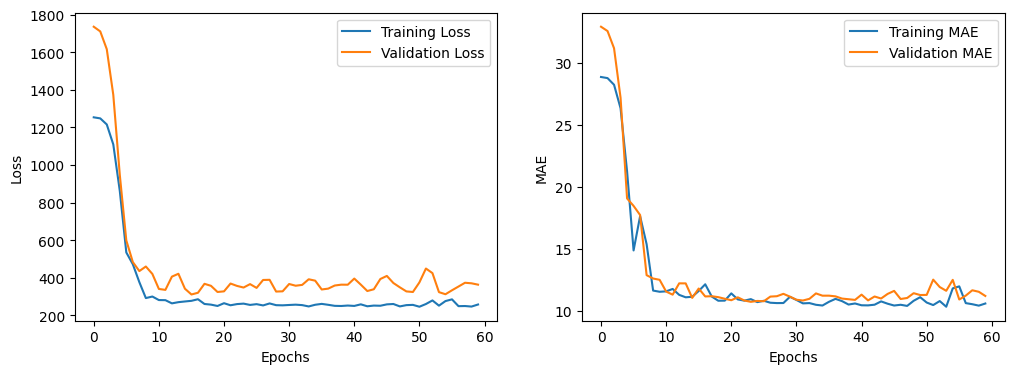

In [6]:
import matplotlib.pyplot as plt


# Evaluate the model
loss, mae = model.evaluate(mask_volume_test, TOS_volume_test)

# Plot the training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the training and validation MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()

Mean Squared Error on Test Set: 201.92704517704516
Sample 0
Predicted: [16 16 15 16 15 15 15 17 16 16 15 16 16 16 16 16 14 15 16 15 15 16 16 16
 15 16 15 17 17 19 17 19 20 21 21 22 24 25 27 28 30 32 33 35 36 38 39 41
 42 42 44 46 47 48 50 50 51 51 52 53 53 52 53 53 51 51 51 49 49 49 48 47
 46 45 43 43 42 40 39 38 36 35 34 33 30 30 28 27 27 25 24 24 23 22 21 20
 20 20 18 18 17 18 17 16 17 16 15 16 16 16 16 17 15 16 14 16 17 16 15 15
 15 15 16 16 15 16]
Actual: [17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 18 20 23 25 28 31 33
 36 39 42 44 47 49 51 53 55 56 58 59 61 62 63 64 64 65 65 66 66 67 67 67
 67 67 67 67 67 66 66 65 65 64 63 63 62 61 60 58 57 55 54 52 50 48 45 43
 40 37 35 32 28 26 23 20 18 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17]

Sample 1
Predicted: [16 16 15 16 16 15 15 17 16 16 15 16 16 16 16 17 14 15 16 15 15 16 16 16
 16 16 15 17 17 19 17 19 20 21 21 22 24 25 27 28 30 32 33

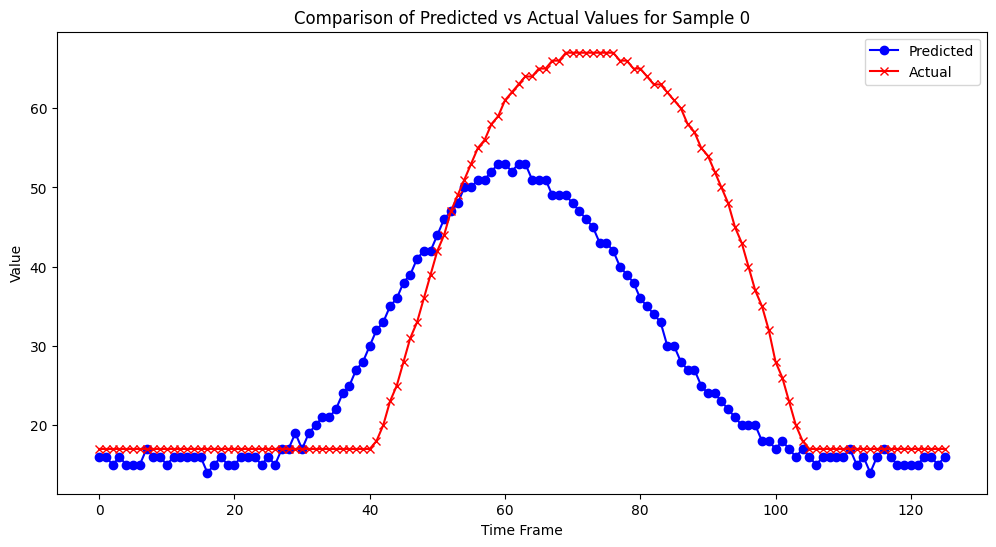

In [7]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Assuming mask_volume_test is your test data and TOS_volume_test is the ground truth

# Make predictions
predictions = model.predict(mask_volume_test)

rounded_predictions = np.round(predictions).astype(int)


# Calculate Mean Squared Error
mse = mean_squared_error(TOS_volume_test_int, rounded_predictions)
print("Mean Squared Error on Test Set:", mse)

# Optionally, display some predictions and actual values
num_samples_to_display = 5  # You can adjust this number

for i in range(num_samples_to_display):
    print("Sample", i)
    print("Predicted:", rounded_predictions[i])
    print("Actual:", TOS_volume_test_int[i])
    print()

import matplotlib.pyplot as plt

# Select a sample to display
sample_index = 0  # Adjust this index to choose different samples

# Get the predicted and actual values for the selected sample
predicted_sample = rounded_predictions[sample_index]
actual_sample = TOS_volume_test_int[sample_index]

# Create a plot
plt.figure(figsize=(12, 6))
plt.plot(predicted_sample, label='Predicted', color='blue', marker='o')
plt.plot(actual_sample, label='Actual', color='red', marker='x')
plt.title(f"Comparison of Predicted vs Actual Values for Sample {sample_index}")
plt.xlabel('Time Frame')
plt.ylabel('Value')
plt.legend()
plt.show()

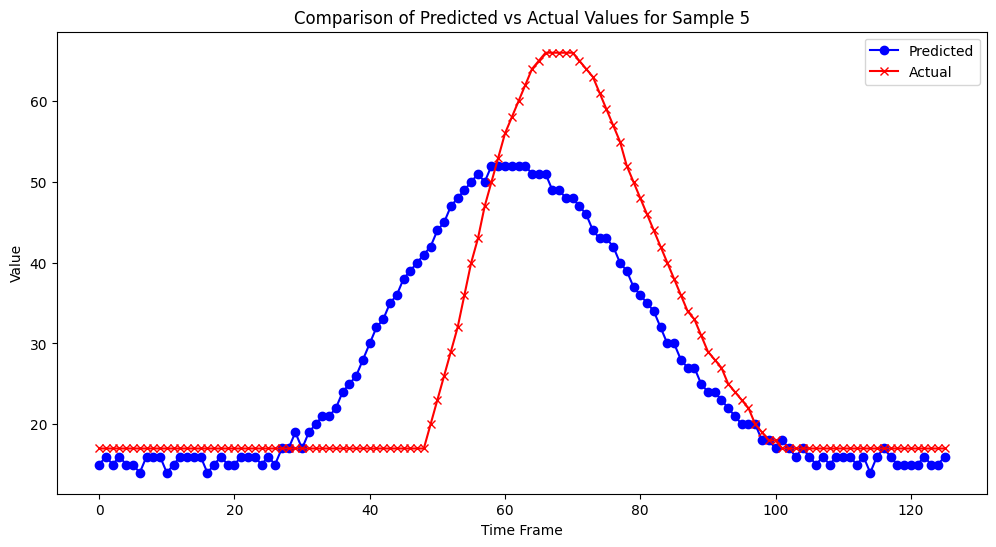

In [8]:
# Select a sample to display
sample_index = 5  # Adjust this index to choose different samples

# Get the predicted and actual values for the selected sample
predicted_sample = rounded_predictions[sample_index]
actual_sample = TOS_volume_test_int[sample_index]

# Create a plot
plt.figure(figsize=(12, 6))
plt.plot(predicted_sample, label='Predicted', color='blue', marker='o')
plt.plot(actual_sample, label='Actual', color='red', marker='x')
plt.title(f"Comparison of Predicted vs Actual Values for Sample {sample_index}")
plt.xlabel('Time Frame')
plt.ylabel('Value')
plt.legend()
plt.show()

## Extra: 3D CNN with more layers (Dint perform as expected)

In [35]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# Define an enhanced 3D CNN with additional improvements
def create_enhanced_3d_cnn(input_shape, num_outputs):
    model = models.Sequential()
    
    # First block with Batch Normalization
    model.add(layers.Conv3D(64, (3, 3, 3), padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Conv3D(64, (3, 3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling3D((2, 2, 2)))

    # First block with Batch Normalization
    model.add(layers.Conv3D(128, (3, 3, 3), padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Conv3D(128, (3, 3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling3D((2, 2, 2)))

    # Final block before Dense layers
    model.add(layers.Conv3D(512, (3, 3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.GlobalAveragePooling3D())

    # Dropout and Dense layers
    model.add(layers.Dropout(0.5))  # Increased dropout for earlier layers
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))  # Maintaining higher dropout before final layer
    model.add(layers.Dense(num_outputs, activation='linear'))  # Using linear activation for output

    return model

# Model parameters
input_shape = (80, 80, 25, 1)  # Update as per your dataset
num_outputs = 126  # Update based on your regression targets

# Create and compile the enhanced 3D CNN model
model = create_enhanced_3d_cnn(input_shape, num_outputs)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Define callbacks
lr_scheduler = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10)
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Fit the model to the training data with callbacks
history = model.fit(mask_volume_train, TOS_volume_train_int, epochs=60, batch_size=25, 
                    validation_split=0.1, callbacks=[lr_scheduler])


Epoch 1/60
5/5 [==============================] - 4s 540ms/step - loss: 1205.4185 - mean_absolute_error: 28.1168 - val_loss: 1798.9229 - val_mean_absolute_error: 33.3782 - lr: 0.0010
Epoch 2/60
5/5 [==============================] - 3s 530ms/step - loss: 1040.2994 - mean_absolute_error: 25.1546 - val_loss: 1710.3519 - val_mean_absolute_error: 32.1240 - lr: 0.0010
Epoch 3/60
5/5 [==============================] - 3s 534ms/step - loss: 761.9208 - mean_absolute_error: 18.8917 - val_loss: 1453.0619 - val_mean_absolute_error: 28.0591 - lr: 0.0010
Epoch 4/60
5/5 [==============================] - 3s 562ms/step - loss: 478.6656 - mean_absolute_error: 13.4329 - val_loss: 1046.7839 - val_mean_absolute_error: 20.4906 - lr: 0.0010
Epoch 5/60
5/5 [==============================] - 3s 549ms/step - loss: 341.1156 - mean_absolute_error: 13.3419 - val_loss: 794.6988 - val_mean_absolute_error: 16.5118 - lr: 0.0010
Epoch 6/60
5/5 [==============================] - 3s 560ms/step - loss: 293.7927 - mean_a

Mean Squared Error on Test Set: 357.31196581196576
Sample 0
Predicted: [ 8  9  9  9  8  9  8  9  8  9  8  9  8  8  9  9  8  8  9  8  8  9  8  8
  9  9  9  9  9  9 10 10 10 11 11 11 12 12 13 13 14 15 15 16 18 19 19 20
 21 22 22 24 25 26 25 27 27 27 27 29 28 29 28 28 28 28 28 27 27 26 26 24
 24 24 24 22 21 22 20 20 19 19 18 17 16 16 15 15 15 14 13 12 12 12 11 11
 11 10 10 10  9  9  9 10  9  9  9  9  8  9 10  8  9  8  8  9  9  8  9  9
  8  9  9  8  8  8]
Actual: [17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 18 20 23 25 28 31 33
 36 39 42 44 47 49 51 53 55 56 58 59 61 62 63 64 64 65 65 66 66 67 67 67
 67 67 67 67 67 66 66 65 65 64 63 63 62 61 60 58 57 55 54 52 50 48 45 43
 40 37 35 32 28 26 23 20 18 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17]

Sample 1
Predicted: [ 8  9  9  9  8  9  8  9  8  9  8  9  8  8  9  9  8  8  9  8  8  9  8  8
  9  9  9  9  9  9 10 10 10 11 11 11 12 12 13 13 14 15 15

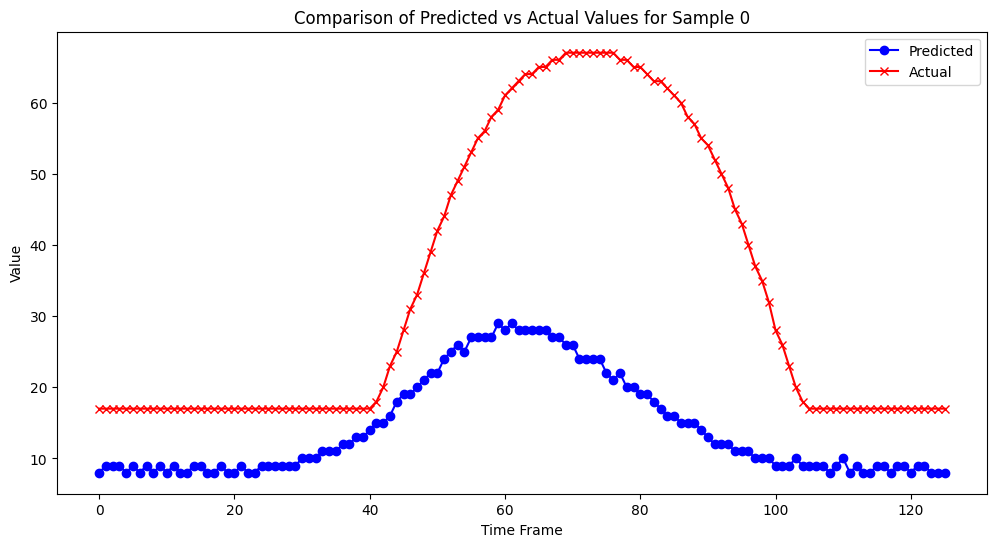

In [36]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Assuming mask_volume_test is your test data and TOS_volume_test is the ground truth

# Make predictions
predictions = model.predict(mask_volume_test)

rounded_predictions = np.round(predictions).astype(int)


# Calculate Mean Squared Error
mse = mean_squared_error(TOS_volume_test_int, rounded_predictions)
print("Mean Squared Error on Test Set:", mse)

# Optionally, display some predictions and actual values
num_samples_to_display = 5  # You can adjust this number

for i in range(num_samples_to_display):
    print("Sample", i)
    print("Predicted:", rounded_predictions[i])
    print("Actual:", TOS_volume_test_int[i])
    print()

import matplotlib.pyplot as plt

# Select a sample to display
sample_index = 0  # Adjust this index to choose different samples

# Get the predicted and actual values for the selected sample
predicted_sample = rounded_predictions[sample_index]
actual_sample = TOS_volume_test_int[sample_index]

# Create a plot
plt.figure(figsize=(12, 6))
plt.plot(predicted_sample, label='Predicted', color='blue', marker='o')
plt.plot(actual_sample, label='Actual', color='red', marker='x')
plt.title(f"Comparison of Predicted vs Actual Values for Sample {sample_index}")
plt.xlabel('Time Frame')
plt.ylabel('Value')
plt.legend()
plt.show()

# Note
Further more expriments can be done on 3D CNN architecure.
However due to limited time in the course we are stooping here with the previous few layers architecture.